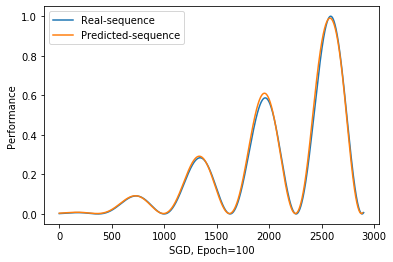

In [13]:
import torch
import torch.nn as nn
from torch.autograd import *
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import time
from datetime import datetime

INPUT_SIZE=1
HIDDEN_SIZE=16
TIME_STEP=10

EPOCH=100
TRAIN_RATE=0.8
DATA_SIZE=30

# OPIMIZER='Adam'
OPIMIZER='SGD'
def SeriesGen(N):
    x = torch.arange(1, N, 0.01)
#     return torch.sin(x)#+torch.cos(x)+torch.pow(x,2)
    return torch.sin(x)*x*x+torch.cos(x)+torch.pow(x,2)


def trainDataGen(seq, k):
    dat = list()
    L = len(seq)
    for i in range(L - k - 1):
        indat = seq[i:i + k]
        outdat = seq[i + k :i + k + 1]
        # print(indat)
        # print(outdat)
        dat.append((indat, outdat))
    return dat

'''数据归一化到0-1'''
def normalization(y):
    max_value = np.max(y)
    min_value = np.min(y)
    scalar = max_value - min_value
    y = list(map(lambda x: x / scalar, y))
    return  y

'''产生数据'''

y = SeriesGen(DATA_SIZE).numpy()
y=normalization(y)
dat = trainDataGen(y, TIME_STEP)

'''训练数据和测试数据设置'''
train_size = int(len(dat) * TRAIN_RATE)
test_size = len(dat) - train_size
train_y = dat[:train_size]
test_y = dat[train_size:]


# test_x = range(int(len(dat) * TRAIN_RATE), len(dat))



class LSTMpred(nn.Module):

    def __init__(self, input_size, hidden_dim):
        super(LSTMpred, self).__init__()
        self.input_dim = input_size
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_size, hidden_dim)
        self.hidden2out = nn.Linear(hidden_dim, 1)
    #     self.hidden = self.init_hidden()
    #
    # def init_hidden(self):
    #     return (Variable(torch.zeros(1, 1, self.hidden_dim)),
    #             Variable(torch.zeros(1, 1, self.hidden_dim)))

    def forward(self, seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq), 1, -1))

        # print('seq.view(len(seq), 1, -1)', seq.view(len(seq), 1, -1).shape)
        # print('lstm_out', lstm_out.shape)

        outdat = self.hidden2out(lstm_out.view(len(seq), -1))

        # print('lstm_out.view(len(seq), -1)',lstm_out.view(len(seq), -1).shape)
        return outdat[9,:]


def ToVariable(x):
    tmp = torch.FloatTensor(x)
    return Variable(tmp)


def model_training():
    print('Start training...')
    t0=time.time()

    model = LSTMpred(INPUT_SIZE, HIDDEN_SIZE).cuda()
    print('Model:',model)
    loss_function = nn.MSELoss()
    if OPIMIZER=='Adam':
        optimizer = optim.Adam(model.parameters(), lr=0.01)
    else:
        optimizer = optim.SGD(model.parameters(), lr=0.001)

    for epoch in range(EPOCH):
        for seq, outs in train_y:
            # print(outs.shape)
            seq = ToVariable(seq).cuda()
            outs = ToVariable(outs).cuda()
            # outs=torch.unsqueeze(outs,1)
            # outs = torch.from_numpy(np.array([outs]))

            optimizer.zero_grad()

            # model.hidden = model.init_hidden()

            modout = model(seq)

            loss = loss_function(modout, outs)
            loss.backward()
            optimizer.step()
        tim1 = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        print(tim1,'Epoch:',epoch,'Loss:',loss.cpu().data.numpy())

    t1 = time.time() - t0
    print('Training time: ', t1)
    torch.save(model,'model_rnn_10_1.pkl')

def model_test():
    model=torch.load('model_rnn_10_1.pkl')

    predDat = []
    for seq, trueVal in dat:
        seq = ToVariable(seq).cuda()
        trueVal = ToVariable(trueVal).cuda()
        # predDat.append(model(seq)[-1].data.numpy()[0])
        predDat.append(model(seq).cpu().data.numpy())

    fig = plt.figure()
    plt.xlabel(OPIMIZER + ', Epoch=%s' % EPOCH)
    plt.ylabel(r'Performance')
    plt.plot(y, label='Real-sequence')
    plt.plot(predDat, label='Predicted-sequence')
    plt.legend(loc=2, ncol=1)
    plt.show()

if __name__ == '__main__':
    torch.cuda.set_device(0)

#     model_training()

    model_test()
